# Final Calibrated XGBoost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, mean_squared_error, confusion_matrix

In [4]:
data = pd.read_csv('./data/data_processed.csv')

data['target'] = data['readmitted'].isin(['<30']).astype(int)

data = data.drop(columns='readmitted')

In [5]:
X = data.drop(columns = 'target')
y = data['target']

In [6]:
X['strat_col'] = X['race'].astype(str) + "_" + data['target'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

X_test_copy = X_test.copy(deep = True)

X_train = X_train.drop(columns = ['strat_col' , 'race'])
X_test = X_test.drop(columns = ['strat_col' , 'race'])

In [7]:
def custom_fit(alg, train_x, train_y, cv_folds=5, early_stopping_rounds=50):
    
    
    xgb_parameters = alg.get_xgb_params()
    xgb_train = xgboost.DMatrix(train_x.values, label=train_y.values)
    cross_val = xgboost.cv(xgb_parameters, xgb_train, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cross_val.shape[0])
    
    #fitting the training data
    alg.fit(train_x, train_y)
        
    y_pred = alg.predict(train_x)
    y_predprobs = alg.predict_proba(train_x)[:,1]
    
    print ("\nModel Report")
    print ("Cassification report:\n", classification_report(train_y, y_pred))
    print ("Accuracy : ", accuracy_score(train_y, y_pred))
    print ("AUC Score : " , roc_auc_score(train_y, y_predprobs))


In [8]:
#with a reasonable set of parameters (not calibrated)

xgb = XGBClassifier(
 learning_rate=0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=3,
 gamma=0.01,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 n_jobs=-1,
 scale_pos_weight=1,
 seed=42)

custom_fit(xgb, X_train, y_train)


Model Report
Cassification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94     68785
           1       0.82      0.11      0.19      8901

    accuracy                           0.89     77686
   macro avg       0.86      0.55      0.57     77686
weighted avg       0.89      0.89      0.86     77686

Accuracy :  0.894974641505548
AUC Score :  0.8623467521395098


### Using grid search to tune

#### First search: `max_depth` and `min_child_weight`

In [9]:
%%time
best_params_GS = {}

param_test_1 = {
    'max_depth': range(3, 11, 1),
    'min_child_weight': range(1, 11, 1)
}
gsearch_1 = GridSearchCV(estimator = XGBClassifier(objective= 'binary:logistic', random_state = 42), 
 param_grid = param_test_1, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_1.fit(X_train,y_train)

best_params_GS.update(gsearch_1.best_params_)
print("The best parameters are:", gsearch_1.best_params_)
print("Best AUC score = ",gsearch_1.best_score_)

The best parameters are: {'max_depth': 4, 'min_child_weight': 10}
Best AUC score =  0.8209767586124028
CPU times: total: 6.66 s
Wall time: 50.5 s


#### Second search: `gamma`

In [10]:
%%time

param_test_2 = {'gamma': np.linspace(0, 1, 10)}

gsearch_2 = GridSearchCV(estimator = XGBClassifier(**best_params_GS, objective= 'binary:logistic', random_state = 42), 
 param_grid = param_test_2, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_2.fit(X_train,y_train)

best_params_GS.update(gsearch_2.best_params_)
print("The best parameters are:", gsearch_2.best_params_)
print("Best AUC score = ",gsearch_2.best_score_)

The best parameters are: {'gamma': np.float64(1.0)}
Best AUC score =  0.8213625653709962
CPU times: total: 2.73 s
Wall time: 5.51 s


#### Third search: `subsample` and `colsample_bytree`

In [11]:
%%time

param_test_3 = {
    'subsample': np.linspace(0.5, 1, 10),
    'colsample_bytree': np.linspace(0.5, 1, 10)
}

gsearch_3 = GridSearchCV(estimator = XGBClassifier(**best_params_GS, objective= 'binary:logistic', random_state = 42), 
 param_grid = param_test_3, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_3.fit(X_train,y_train)

best_params_GS.update(gsearch_3.best_params_)
print("The best parameters are:", gsearch_3.best_params_)
print("Best AUC score = ",gsearch_3.best_score_)

The best parameters are: {'colsample_bytree': np.float64(1.0), 'subsample': np.float64(1.0)}
Best AUC score =  0.8213625653709962
CPU times: total: 5.97 s
Wall time: 54.8 s


#### Fourth search: `n_estimators` and `learning_rate`

In [12]:
%%time

param_test_4 = {
    'n_estimators': range(200, 1000, 100),
    'learning_rate': np.logspace(-3,0,10)
}

gsearch_4 = GridSearchCV(estimator = XGBClassifier(**best_params_GS, objective= 'binary:logistic', random_state = 42), 
 param_grid = param_test_4, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_4.fit(X_train,y_train)

best_params_GS.update(gsearch_4.best_params_)
print("The best parameters are:", gsearch_4.best_params_)
print("Best AUC score = ",gsearch_4.best_score_)

The best parameters are: {'learning_rate': np.float64(0.046415888336127774), 'n_estimators': 400}
Best AUC score =  0.8224225664295173
CPU times: total: 9.5 s
Wall time: 2min 38s


#### Final search: `reg_apha` and `reg_lambda`

In [13]:
%%time

param_test_5 = {
    'reg_alpha': np.logspace(-4,2,10),
    'reg_lambda': np.logspace(-4,2,10)
}

gsearch_5 = GridSearchCV(estimator = XGBClassifier(**best_params_GS, objective= 'binary:logistic', random_state = 42), 
 param_grid = param_test_5, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_5.fit(X_train,y_train)

best_params_GS.update(gsearch_5.best_params_)
print("The best parameters are:", gsearch_5.best_params_)
print("Best AUC score = ",gsearch_5.best_score_)

The best parameters are: {'reg_alpha': np.float64(0.046415888336127774), 'reg_lambda': np.float64(1.0)}
Best AUC score =  0.8226395504963848
CPU times: total: 9.75 s
Wall time: 2min 24s


In [14]:
#final list of tuned parameters
best_params_GS

{'max_depth': 4,
 'min_child_weight': 10,
 'gamma': np.float64(1.0),
 'colsample_bytree': np.float64(1.0),
 'subsample': np.float64(1.0),
 'learning_rate': np.float64(0.046415888336127774),
 'n_estimators': 400,
 'reg_alpha': np.float64(0.046415888336127774),
 'reg_lambda': np.float64(1.0)}

### Alternate: Using Random Search

In [15]:
%%time

parameters = {
    'max_depth': range(3, 11, 1),
    'min_child_weight': range(1, 11, 1),
    'gamma': np.linspace(0, 1, 10),
    'subsample': np.linspace(0.5, 1, 10),
    'colsample_bytree': np.linspace(0.5, 1, 10),
    'n_estimators': range(200, 1000, 100),
    'learning_rate': np.logspace(-3,0,10),
    'reg_alpha': np.logspace(-4,2,10),
    'reg_lambda': np.logspace(-4,2,10)
}

xgb = XGBClassifier(objective= 'binary:logistic', random_state = 42)

random_search = RandomizedSearchCV(estimator = xgb, n_iter = 50,
                           param_distributions=parameters,
                           scoring = 'roc_auc',
                           n_jobs=-1, verbose=1, cv=5)

random_search.fit(X_train, y_train)

best_params_RS = random_search.best_params_

print("Best parameters:\n",random_search.best_params_,"\n")
print("Best AUC score = ",random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:
 {'subsample': np.float64(0.8888888888888888), 'reg_lambda': np.float64(0.00046415888336127773), 'reg_alpha': np.float64(4.641588833612772), 'n_estimators': 900, 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': np.float64(0.046415888336127774), 'gamma': np.float64(0.8888888888888888), 'colsample_bytree': np.float64(0.7222222222222222)} 

Best AUC score =  0.8243338049381268
CPU times: total: 15.7 s
Wall time: 2min 51s


In this case, the random search managed to get a better AUC score, so we will stick with the parameters.

In [16]:
best_params_RS

{'subsample': np.float64(0.8888888888888888),
 'reg_lambda': np.float64(0.00046415888336127773),
 'reg_alpha': np.float64(4.641588833612772),
 'n_estimators': 900,
 'min_child_weight': 9,
 'max_depth': 5,
 'learning_rate': np.float64(0.046415888336127774),
 'gamma': np.float64(0.8888888888888888),
 'colsample_bytree': np.float64(0.7222222222222222)}

In [17]:
best_params = best_params_RS#best_params_GS

### Final fit and evaluation

In [18]:
xgbCal = XGBClassifier(**best_params, object = 'binary:logistic', random_state=42)

custom_fit(xgbCal, X_train, y_train)
#xgbCal.get_params()

c:\Users\Souradeep\anaconda3\envs\erdos_summer_2025\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:41:05] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Souradeep\anaconda3\envs\erdos_summer_2025\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:41:25] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "object" } are not used.

  warnings.warn(smsg, UserWarning)



Model Report
Cassification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94     68785
           1       0.82      0.13      0.22      8901

    accuracy                           0.90     77686
   macro avg       0.86      0.56      0.58     77686
weighted avg       0.89      0.90      0.86     77686

Accuracy :  0.89660942769611
AUC Score :  0.8650291242483927


In [19]:
probs = xgbCal.predict_proba(X_test)
y_pred = (probs[:, 1]>=0.5)

Confusion Matrix:
[[17075   122]
 [ 2061   164]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     17197
           1       0.57      0.07      0.13      2225

    accuracy                           0.89     19422
   macro avg       0.73      0.53      0.54     19422
weighted avg       0.86      0.89      0.85     19422

Mean squared error =  0.11239831119349192
Accuracy =  0.8876016888065081
ROC AUC score =  0.8206386663992217


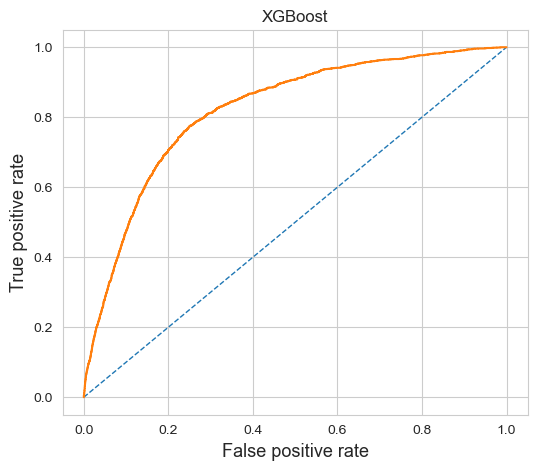

In [20]:
mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, probs[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)

roc_data = pd.DataFrame({'X': false_pos_rate.tolist(), 'Y': true_pos_rate.tolist()})
roc_data.to_csv('./figs/plot_data/roc_curve_xgb.csv', index=False)
    

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Mean squared error = ",mse)
print("Accuracy = ",acc)
print("ROC AUC score = ",roc_auc)

plt.figure(figsize = (6,5))
plt.plot([0,1], [0,1], '--', lw=1)
plt.plot(false_pos_rate, true_pos_rate)
plt.xlabel('False positive rate', fontsize=13)
plt.ylabel('True positive rate', fontsize=13)
plt.title('XGBoost')
plt.show()

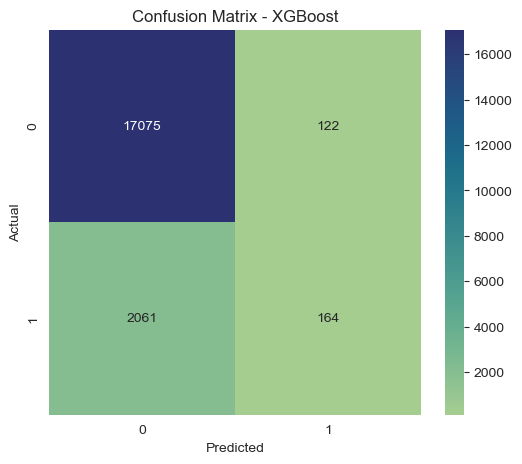

Confusion Matrix:
 [[17075   122]
 [ 2061   164]]


In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, cmap='crest', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')

plt.savefig('./figs/conf_mat_xgb.png')
plt.show()

# Print confusion matrix and classification report for detailed metrics
print("Confusion Matrix:\n", cm)

In [80]:
feat_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgbCal.feature_importances_
}).sort_values(by='Importance', ascending=False)

feat_importances

,Feature,Importance
85,pt_inp_tot,0.158818
7,number_inpatient,0.068767
87,pt_diag_tot,0.066701
23,discharge_longterm_ind,0.028802
49,pt_diag_ct,0.027621
...,...,...
32,otherrace_ind,0.000000
65,d_congenital_ind,0.000000
66,d_perinatal_ind,0.000000
62,d_pegnancy_ind,0.000000


In [70]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [79]:
print(feat_importances.head().to_markdown(index=False))

| Feature                |   Importance |
|:-----------------------|-------------:|
| pt_inp_tot             |    0.158818  |
| number_inpatient       |    0.0687674 |
| pt_diag_tot            |    0.0667006 |
| discharge_longterm_ind |    0.0288018 |
| pt_diag_ct             |    0.0276208 |


In [36]:
roc_logreg_unpr = pd.read_csv('./figs/plot_data/roc_curve_logreg-unpr.csv')
roc_logreg = pd.read_csv('./figs/plot_data/roc_curve_logreg.csv')
roc_kNN = pd.read_csv('./figs/plot_data/roc_curve_kNN.csv')
roc_rf = pd.read_csv('./figs/plot_data/roc_curve_rf.csv')
roc_xgb = pd.read_csv('./figs/plot_data/roc_curve_xgb.csv')

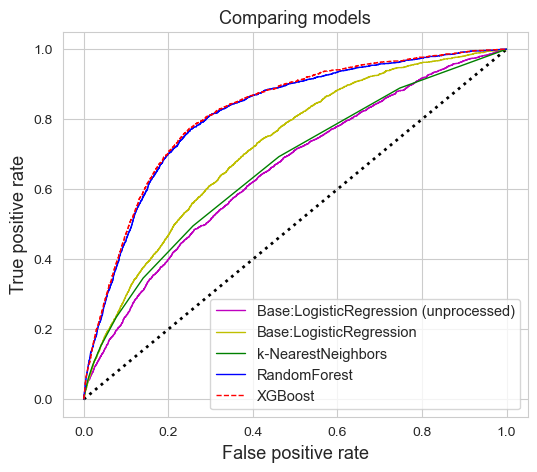

In [64]:
plt.figure(figsize = (6,5))
plt.plot([0,1], [0,1], 'k:', lw=2)
plt.plot(roc_logreg_unpr.X,roc_logreg_unpr.Y,'m',label='Base:LogisticRegression (unprocessed)', linewidth=1)
plt.plot(roc_logreg.X,roc_logreg.Y,'y',label='Base:LogisticRegression', linewidth=1)
plt.plot(roc_kNN.X,roc_kNN.Y,'g',label='k-NearestNeighbors', linewidth=1)
plt.plot(roc_rf.X,roc_rf.Y,'b',label='RandomForest', linewidth=1)
plt.plot(roc_xgb.X,roc_xgb.Y,'r',label='XGBoost', linestyle='dashed', linewidth=1)
plt.xlabel('False positive rate', fontsize=13)
plt.ylabel('True positive rate', fontsize=13)
plt.title('Comparing models', fontsize=13)
plt.legend(fontsize=10.5)

plt.savefig('./figs/roc_all.png')
plt.show()

### Metrics by demographics
#### Race

In [38]:
races = X_test_copy.race.unique()
hist_race = pd.DataFrame({'race':races})

In [39]:
for r in races:
    test_X = X_test.loc[X_test_copy['race'] == r]
    test_y = y_test.loc[X_test_copy['race'] == r]
    pred_y = xgbCal.predict(test_X)
    pred_probs_y = xgbCal.predict_proba(test_X)

    hist_race.loc[hist_race['race']==r,'Accuracy score']= accuracy_score(test_y,pred_y)
    hist_race.loc[hist_race['race']==r,'AUC score']= roc_auc_score(test_y,pred_probs_y[:,1])

hist_race['Fraction of data'] = X_test_copy['race'].value_counts().values/len(X_test_copy)

<Figure size 1400x600 with 0 Axes>

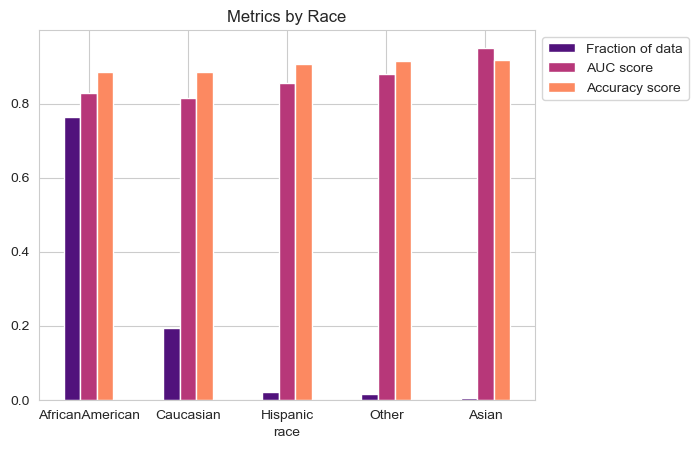

In [65]:
plt.figure(figsize=(14,6))
palette = sns.color_palette('magma', n_colors=3)
ax = hist_race.plot(x='race', y=['Fraction of data','AUC score','Accuracy score'], kind='bar', rot=0, color=palette)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title('Metrics by Race')
#plt.tight_layout()
plt.savefig('./figs/met_by_race.png', bbox_inches='tight')
plt.show()

#### Age

In [41]:
#re-mapping ages

age_map = {
    '0': '[0-10)',
    '1': '[10-20)',
    '2': '[20-30)',
    '3': '[30-40)',
    '4': '[40-50)',
    '5': '[50-60)',
    '6': '[60-70)',
    '7': '[70-80)',
    '8': '[80-90)',
    '9': '[90-100)'
}

X_test_copy['age_new'] = X_test_copy['age'].astype(str).map(age_map)

In [42]:
ages = X_test_copy.age_new.unique()
hist_age = pd.DataFrame({'ages':sorted(ages)})

In [43]:
for r in ages:
    test_X = X_test.loc[X_test_copy['age_new'] == r]
    test_y = y_test.loc[X_test_copy['age_new'] == r]
    pred_y = xgbCal.predict(test_X)
    pred_probs_y = xgbCal.predict_proba(test_X)

    hist_age.loc[hist_age['ages']==r,'Accuracy score']= accuracy_score(test_y,pred_y)
    hist_age.loc[hist_age['ages']==r,'AUC score']= roc_auc_score(test_y,pred_probs_y[:,1])

hist_age['Fraction of data'] = X_test_copy['age_new'].value_counts().sort_index().values/len(X_test_copy)

<Figure size 1600x600 with 0 Axes>

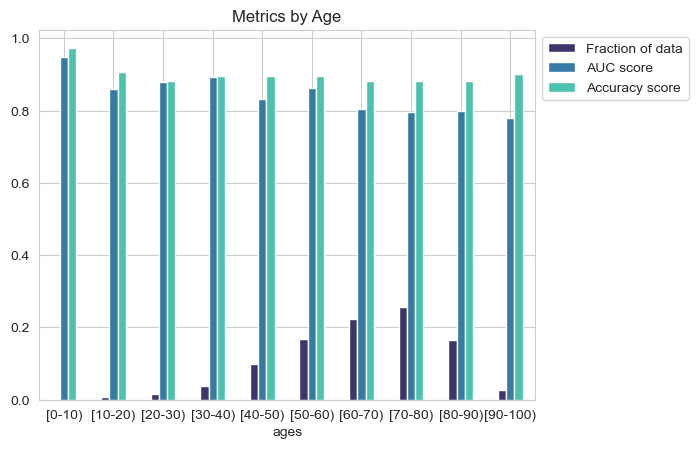

In [66]:
plt.figure(figsize=(16,6))
palette = sns.color_palette('mako', n_colors=3)
ax = hist_age.plot(x='ages', y=['Fraction of data','AUC score','Accuracy score'], kind='bar', rot=0, color=palette)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title('Metrics by Age')
#plt.tight_layout()
plt.savefig('./figs/met_by_age.png', bbox_inches='tight')
plt.show()

#### Gender

In [45]:
#re-mapping ages

X_test_copy['gender'] = np.where(X_test_copy['male_ind'] == 1, 'Male', 'Female')

In [46]:
genders = X_test_copy.gender.unique()
hist_gender = pd.DataFrame({'genders':sorted(genders)})

In [47]:
for r in genders:
    test_X = X_test.loc[X_test_copy['gender'] == r]
    test_y = y_test.loc[X_test_copy['gender'] == r]
    pred_y = xgbCal.predict(test_X)
    pred_probs_y = xgbCal.predict_proba(test_X)

    hist_gender.loc[hist_gender['genders']==r,'Accuracy score']= accuracy_score(test_y,pred_y)
    hist_gender.loc[hist_gender['genders']==r,'AUC score']= roc_auc_score(test_y,pred_probs_y[:,1])

hist_gender['Fraction of data'] = X_test_copy['gender'].value_counts().sort_index().values/len(X_test_copy)

<Figure size 1200x600 with 0 Axes>

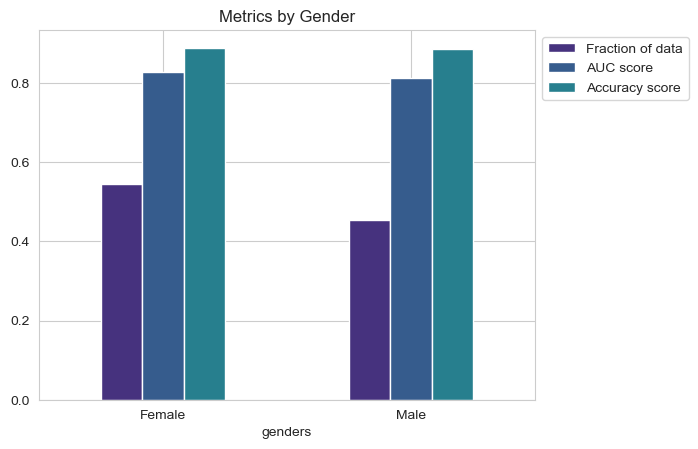

In [67]:
plt.figure(figsize=(12,6))
palette = sns.color_palette('viridis')
ax = hist_gender.plot(x='genders', y=['Fraction of data','AUC score','Accuracy score'], kind='bar', rot=0, color=palette)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title('Metrics by Gender')
#plt.tight_layout()
plt.savefig('./figs/met_by_gender.png', bbox_inches='tight')
plt.show()